# Detector characterization

- [ 1 - Introduction ](#1)
- [ 2 - Packages](#2)
- [ 3 - Data set](#3)
- [ 4 - Calibration](#4)
  - [ 4.1 Residual resistance](#4.1)
  - [ 4.2 Bias inductance](#4.2)
- [ 5 - Detector Characterization](#5)
  - [ 5.1 Parameter extraction](#5.1)
  - [ 5.2 Statistics](#5.2)

<a name="1"></a>
# 1 - Introduction

This notebook goes through the analysis process used to characterize and QC superconducting sensors for the POLARBEAR-2 (PB-2) telescopes based on measurements performed in our laboratory at UCSD. We have successfully deployed the first two PB-2 telescopes with a full complement of over 15,000 superconducting sensors.

Strict requirements were placed on the thermal and electrical properties and yield of the detectors in order to ensure that PB-2 would achieve it's science goals. The sensors are fabricated on 150 mm silicon wafers with over 1,000 sensors per wafer. In total the PB-2 telescopes required 14 wafers of detectors. In our R&D phase, we fabricated quite a few more than wer

The rest of this section is meant to provide some context by describing the PB-2 experiment and it's science goals and then to give some background on the physics of the superconducting sensors used. Neither of these sections are necessary in order to understand what follows in the analysis procedure, so feel free to skip them if you're not interested. On the other hand, if you are interested, please read on! And if you have questions (particularly any students), please don't hesitate to send me an email. It would help me to clarify my writing as well. 


All that is required is an understanding of Ohm's law and superconductivity (I'll explain that where needed)

Explanation of detector and IV curve. Why we're doing this and what we're trying to do. Published in JLTP

<a name="2"></a>
# 2 - Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

from utils import load_pkl, convert

<a name="3"></a>

<a name="2"></a>
# 3 - Dataset

In [103]:
db_dir = '/home/tucker/20190225_221113_drop_bolos/data/'
fnames_db = ! ls $db_dir | grep OUTPUT
fnames_db = sorted(fnames_db)

For each detector, we will have a set of current and voltage measurements. The number of data points varies across the set of detectors. I want to have a vectorized implmentation of the data, so I'm going to make an array with size (ndetectors, npts) where npts is the same for all detectors. Ideally, npts would be equal to the maximum number of data points and I can set nans for detectors that don't have npts. But I don't want to open every single detectors data just to find max(npts). Instead I'll just open the first ~400 detectors worth of data and take the max(npts) from that set. That might not give me the absolute maximum npts, but as we'll see later, the final points in a data set are often cut from the analysis, so this approach should be fine.

In [105]:
npts = np.zeros(10)

for i, fname in enumerate(fnames_db[:10]):
    
    data_db = load_pkl(db_dir + fname)        
    npts[i] = len(data_db['RIV_log'][1]['I'])
    
npts = int(np.max(npts))

Each SQUID can have up to 40 detectors. I will assume that the total number of detectors is 40*len(fnames_db)

In [106]:
ndet_orig = len(fnames_db) * 40

In [8]:
Vol_orig = np.zeros((ndet_orig, npts))
Cur_orig = np.zeros((ndet_orig, npts))
frq_orig = np.zeros(ndet_orig)
det_id = []

for j, fname in enumerate(fnames_db):

    data_db = load_pkl(db_dir + fname)
    pstring = data_db['pstring']
    
    for ch in data_db['RIV_log']: # note: Ch is indexed from 1
        
        det_id.append(pstring+f'/{ch}')
        
        det = j*40 + ch - 1
        
        v = data_db['RIV_log'][ch]['V']
        Vol_orig[det][:len(v)] = np.array(v[:npts]) * 1e6
        
        i = data_db['RIV_log'][ch]['I']
        Cur_orig[det][:len(i)] = np.array(i[:npts]) * 1e6
        
        frq_orig[det] = data_db['pre_drop'][ch]['freq']

Many of the entires in Vol_orig, Cur_orig, and frq are zeros because we don't actually have data from forty detectors in each file. We can remove those rows by filtering on frq as below:

Let's look at the IV data from a single detector to get a feel for what we're working with

Text(0, 0.5, 'Current [$\\mu$A]')

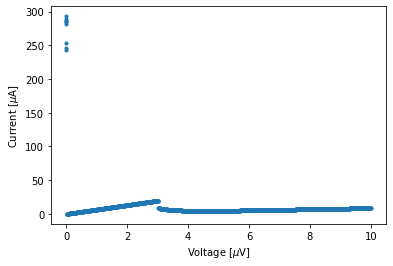

In [9]:
plt.plot(Vol_orig[0], Cur_orig[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

Note the data points in the upper left of the plot. These correspond to very small values of voltage such that the current measurement is not reliable. Ultimately, we'll want to fit a line to the low voltage data and those points will make this inaccurate. Let's apply a cut to data with voltage<0.1 uV. Ultimately the simplest thing to do is to just remove the first few entries for each detector

During this measurement, we typically sweep a large range of voltage so that we have excess data at high and low voltage and it's fine to cut some of it

While we're at it, we can also remove the rows corresponding to not having data

In [10]:
keep_rows = frq_orig != 0
keep_cols = np.repeat(True, Vol_orig.shape[1])
keep_cols[-50:] = False

ixgrid = np.ix_(keep_rows, keep_cols)

Vol = Vol_orig[ixgrid]
Cur = Cur_orig[ixgrid]
frq = frq_orig[keep_rows]

ndet = len(frq)

Now we can take a better look at the data. There are three regions here. Going from right to left: at high voltage the detector is normal and the resistance is constant; at about 4.1 uV, the detector begins to transition and it's resistance decreases; at about 3 uV, the detector becomes unstable and abruptly becomes superconducting (we call this "latching" and below this point there is a constant resistance which is smaller than the normal resistance.

We want to extract three numbers from this plot: The resistance in the first region, the minimum point in regions 1 and 2 (the so-called "turnaround point"), and the resistance in the third region.

In [88]:
'''var = np.var(Cur, axis=1)

plt.plot(np.var(Cur, axis=1), '.')
plt.yscale('log')
plt.show()

print(sum(np.logical_and(var>1e0, var<1e2)))
print(len(var))'''

"var = np.var(Cur, axis=1)\n\nplt.plot(np.var(Cur, axis=1), '.')\nplt.yscale('log')\nplt.show()\n\nprint(sum(np.logical_and(var>1e0, var<1e2)))\nprint(len(var))"

Text(0, 0.5, 'Current [$\\mu$A]')

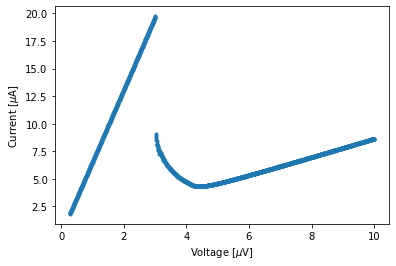

In [43]:
plt.plot(Vol[0], Cur[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

<a name="4"></a>
# 4 - Calibrating data for parasitic impedance

<a name="4.1"></a>
## 4.1 - Residual Resistance

Those of you who are familiar with superconductivity may have noticed something odd in the RV plot above - the resistance is nonzero even when the detector is superconducting. A superconductor has zero resistance, so the residual resistance must be a result of some other part of our circuit that is not superconducting. There are several candidates: connectors, capacitor loss, cable inductance, etc. Our goal here will be to: 1) define a model for the residual resistance, 2) measure the model parameters, and 3) calibrate our measurement to give more accurate detector parameters.

### Residual resistance model

We will use the model shown below. Each detector (R_TES) is in series with a unique residual resistance (R_resid). Ohm's law applied to this circuit yields:  

$$V = I (R_{TES}+R_{resid})$$

The voltage that we have stored in ``Vol`` is this voltage. We will be interested in determining the resistance of the detector and the electrical power dissipated in the detector and for both of those, we will need to calculate the voltage on the detector, V_TES. V_tes is related to V by the following:

$V_{TES} = V \frac{R_{TES}}{R_{TES}+R_{res}} = V (1-\frac{R_{res}}{R_{tot}})$

where $R_{tot} = R_{TES}+R_{resid}$ is the total resistance in the model

Our next task, then, is it determine the coefficient of V in that equation, which I'll call CF1. To do that, we'll need to calculate the R_resid for each detector.

### Measuring residual resistance

In region 3 of the IV curve, the detector is fully superconducting and Ohm's law reduces to

$V = IR_{resid}$

We will use linear regression to determine R_resid given our data.

First let's find the latching point. We can identify the latching point by find the largest derivative in the data set. Note that Vol[ch] starts high and goes down, so we are looking for a large positive derivative. Also, the spacing along the x-axis is constant, so we can just look at the difference in y-values rather than taking a derivative.

In [44]:
latch_pt = np.argmax(np.diff(Cur), axis=1)

Below we can see that this has identified the latching point

Text(0, 0.5, 'Current [$\\mu$A]')

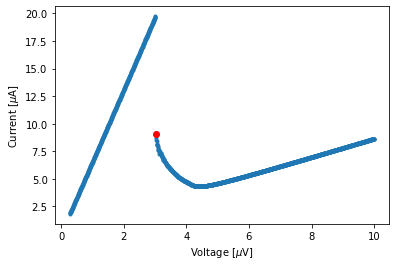

In [54]:
ch = 0
plt.plot(Vol[ch], Cur[ch], '.')
plt.plot(Vol[ch][latch_pt[ch]], Cur[ch][latch_pt[ch]], 'ro')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

In [57]:
# Get residual resistance

R_res = np.zeros((ndet,1))

for k in range(ndet):
    #print(k)
    if latch_pt[k] == 0:
        continue
    
    x = Vol[k][latch_pt[k]+1:].reshape(-1, 1)
    y = Cur[k][latch_pt[k]+1:]
    
    model = LinearRegression()
    model.fit(x, y)
    
    R_res[k] = 1 / model.coef_
    #rr_intercept[k] = model.intercept_

<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-5

<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-5

<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-57-713905c06f70>:16: RuntimeWarning: divide by zero encountered in true_divide
  R_res[k] = 1 / model.coef_
<ipython-input-5

Plots below: we can see that the mean is about 0.3 with a fairly tight distribution. Plotting Rres vs frequency is also illuminating. We can see that there is a pretty tight distribution at a given frequency and the mean is rising with frequency. This is not suprising as dielectric loss and cable inductance tend to increase with frequency.

(array([  0.,  18., 511., 771., 401., 101.,  48.,  32.,  17.,  19.,  10.,
         11.,  79.,  30.,   0.,   1.,   1.,   1.,   0.]),
 array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
        0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
        0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
        1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ]),
 <BarContainer object of 19 artists>)

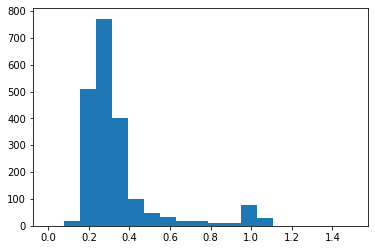

In [73]:
plt.hist(R_res, bins=np.linspace(0, 1.5, 20))

(0.0, 1.5)

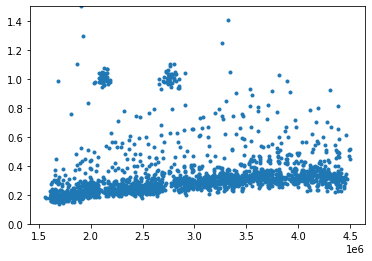

In [75]:
plt.plot(frq, R_res, '.')
plt.ylim(0, 1.5)

### Calibrate measurement

First let's calculate our calibration factor Cf1

In [89]:
Rtot = Vol/Cur
Cf1 = 1 - R_res/Rtot

<ipython-input-89-de61b71771a0>:1: RuntimeWarning: invalid value encountered in true_divide
  Rtot = Vol/Cur


There are a few ways to visualize the effect of Cf1. The most intuitive is probably looking at I-V and R-V curves

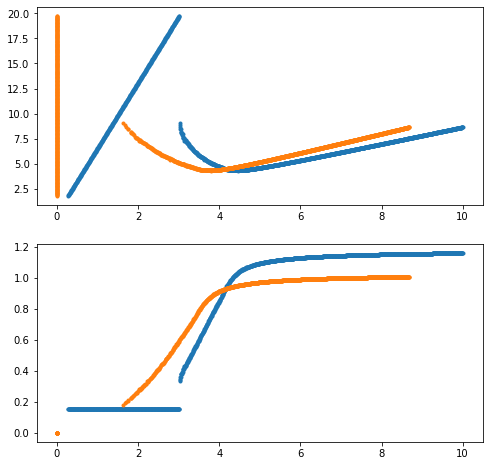

In [99]:
ch = 0
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

ax = axs[0]
ax.plot(Vol[ch], Cur[ch], '.')
ax.plot(Vol[ch]*Cf1[ch], Cur[ch], '.')

ax = axs[1]
ax.plot(Vol[ch], Rtot[ch], '.')
ax.plot(Vol[ch]*Cf1[ch], Rtot[ch]*Cf1[ch], '.')

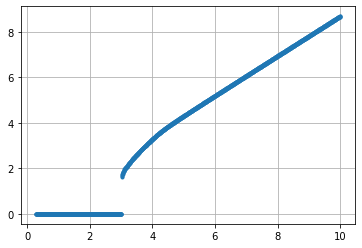

In [87]:
plt.plot(Vol[0], Vol[0]*Cf1[0], '.')
plt.grid()

In [55]:
#Find turnaround
'''#temporarily set all points to the left of latching point to large values
Cur_temp = np.full(Cur.shape, 100.)

for k in range(ndet):
    Cur_temp[k][:latch_pt[k]] = Cur[k][:latch_pt[k]]

turnaround_pt = np.argmin(Cur_temp, axis=1)'''

'#temporarily set all points to the left of latching point to large values\nCur_temp = np.full(Cur.shape, 100.)\n\nfor k in range(ndet):\n    Cur_temp[k][:latch_pt[k]] = Cur[k][:latch_pt[k]]\n\nturnaround_pt = np.argmin(Cur_temp, axis=1)'

In [56]:
# fit normal resistance
'''# take the first half of the data before the turnaround to be the region where the detector is fully normal
normal = (turnaround_pt/2).astype(int)

R_tot = np.zeros((ndet,1))
#rn_intercept = np.zeros(ndet)

for k in range(ndet):
    
    if normal[k] <= 1:
        continue
    
    x = Vol[k][:normal[k]].reshape(-1, 1)
    y = Cur[k][:normal[k]]
    
    model = LinearRegression()
    model.fit(x, y)
    
    R_max[k] = 1 / model.coef_
    #rn_intercept[k] = model.intercept_'''

'# take the first half of the data before the turnaround to be the region where the detector is fully normal\nnormal = (turnaround_pt/2).astype(int)\n\nR_tot = np.zeros((ndet,1))\n#rn_intercept = np.zeros(ndet)\n\nfor k in range(ndet):\n    \n    if normal[k] <= 1:\n        continue\n    \n    x = Vol[k][:normal[k]].reshape(-1, 1)\n    y = Cur[k][:normal[k]]\n    \n    model = LinearRegression()\n    model.fit(x, y)\n    \n    R_max[k] = 1 / model.coef_\n    #rn_intercept[k] = model.intercept_'

Next we're going to apply to calibrations to the data set. I'll motivate them each and then apply the calibration.

First we need to deal with the residual resistance. We will model this as a unique resistance in series with each detector. The values in Vol are voltages applied accross the series combination of a detector and a residual resistance. 

The TES resistance is given by: 

$R_{TES} = R_{tot}-R_{res}$

The voltage across the TES is related to Vol by the following:

$V_{TES} = V \frac{R_{TES}}{R_{TES}+R_{res}} = V (1-\frac{R_{res}}{R_{tot}})$

We'll define the coefficient in this equation as calibration factor 1 (cf1)

For our next calculations, we will want to estimate the voltage across just the detector. Since we have fit for the residual resistance and we can get the total resistance by dividing Vol by Cur, we can do this math. Note that the current through the detector does not need to be calibrated because it is the same current flowing through both elements

In [33]:
R_tot = Vol/Cur
Cf1 = 1 - R_res / R_tot

<ipython-input-33-a54db45ad4a1>:1: RuntimeWarning: invalid value encountered in true_divide
  R_tot = Vol/Cur


Let's take a look at some data with this calibration applied:

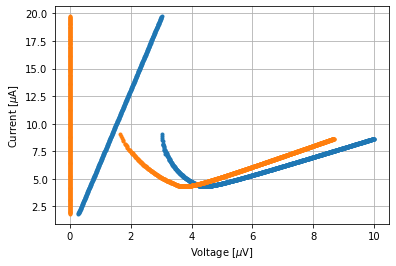

In [38]:
plt.plot(Vol[0], Cur[0], '.')
plt.plot(Vol[0]*Cf1[0], Cur[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

Text(0, 0.5, 'Resistance [$\\Omega$]')

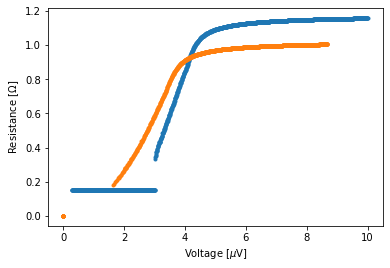

In [41]:
plt.plot(Vol[0], Vol[0]/Cur[0], '.')
plt.plot(Vol[0]*Cf1[0], Vol[0]*Cf1[0]/Cur[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Resistance [$\Omega$]')

Now we'll move onto the next calibration

In [26]:
Vol_tes = Vol * (R_tot-R_res)

<ipython-input-26-842951759207>:1: RuntimeWarning: invalid value encountered in multiply
  Vol_tes = Vol * (R_tot-R_res)


In [27]:
R_tot-R_res

array([[1.04334461],
       [1.2928935 ],
       [1.08674091],
       ...,
       [0.62925168],
       [0.60960801],
       [0.60877794]])

(array([571.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,
          8.,  54., 119., 117., 101., 143., 317., 375., 344., 199., 113.,
         67.,  44.,  35.,  32.,  24.,  21.,  13.,  14.,   9.,  18.,  20.,
          5.,   9.,  14.,  14.,   7.]),
 array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
        0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
        0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
        0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
        0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97959184,
        1.02040816, 1.06122449, 1.10204082, 1.14285714, 1.18367347,
        1.2244898 , 1.26530612, 1.30612245, 1.34693878, 1.3877551 ,
        1.42857143, 1.46938776, 1.51020408, 1.55102041, 1.59183673,
        1.63265306, 1.67346939, 1.71428571, 1.75510204, 1.79591837,
        1.83673469, 1.87755102, 1.91836735, 1.959183

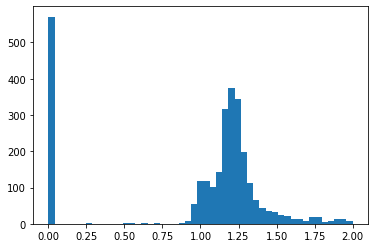

In [83]:
plt.hist(R_n, bins=np.linspace(0, 2))

(0.5, 1.8)

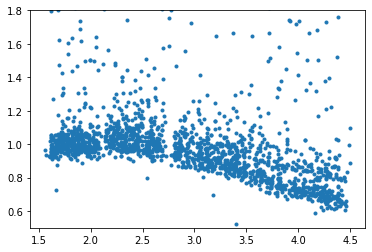

In [24]:
plt.plot(frq/1e6, (R_n-R_res), '.')
plt.ylim(0.5, 1.8)